In [132]:
import numpy as np
from pymc.ode import DifferentialEquation
import corner
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as tt
from pytensor import function
from pytensor.compile.ops import as_op

In [155]:
G = 43018  # 引力常数，单位：kpc (km/s)^2 / 10^10 Msun

# 定义 Galactic 到 ICRS 的旋转矩阵（来自 Astropy 定义）
R_gal2icrs = tt.as_tensor_variable([
    [-0.0548755604, -0.8734370902, -0.4838350155],
    [0.4941094279, -0.4448296300, 0.7469822445],
    [-0.8676661490, -0.1980763734, 0.4559837762]
])



# 太阳位置和速度（Galactocentric 坐标系）
pos_sun_gal = tt.as_tensor_variable([-8.122, 0.0, 0.0208])  # kpc
vel_sun_gal = tt.as_tensor_variable([12.9, 245.6, 7.8])     # km/s

def rotation_matrix_x(theta):
    """
    绕 x 轴旋转的旋转矩阵 (角度 theta)
    参数:
        theta: 绕 x 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return tt.stack([
        [1, 0, 0],
        [0, tt.cos(theta), -tt.sin(theta)],
        [0, tt.sin(theta), tt.cos(theta)]
    ])
    
def rotation_matrix_y(phi):
    """
    绕 y 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 y 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return tt.stack([
        [tt.cos(phi), 0, tt.sin(phi)],
        [0, 1, 0],
        [-tt.sin(phi), 0, tt.cos(phi)]
    ])

def rotation_matrix_z(phi):
    """
    绕 z 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 z 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return tt.stack([
        [tt.cos(phi), -tt.sin(phi), 0],
        [tt.sin(phi), tt.cos(phi), 0],
        [0, 0, 1]
    ])


def galactic_to_icrs(pos, vel):
    """符号化 Galactic 到 ICRS 的坐标转换"""
    # 转换到太阳坐标系
    pos_gal = pos - pos_sun_gal
    vel_gal = vel - vel_sun_gal
    
    # 应用旋转矩阵
    pos_icrs = tt.dot(R_gal2icrs.T, pos_gal)
    vel_icrs = tt.dot(R_gal2icrs.T, vel_gal)
    
    # 计算球坐标
    x, y, z = pos_icrs[0], pos_icrs[1], pos_icrs[2]
    distance = tt.sqrt(x**2 + y**2 + z**2)
    ra = tt.arctan2(y, x) * (180 / np.pi) %360  # 转换为度数
    dec = tt.arcsin(z / distance) * (180 / np.pi)  # 转换为度数
    
    # 计算自行 (mas/yr)
    unit_vec = pos_icrs / distance
    vr = tt.sum(vel_icrs * unit_vec)
    vt_vec = vel_icrs - vr * unit_vec
    
    # 自行方向向量
    east = tt.stack([-tt.sin(ra * np.pi/180), 
                     tt.cos(ra * np.pi/180), 
                    0.0]) 
    north = tt.stack([-tt.cos(ra * np.pi/180) * tt.sin(dec * np.pi/180),
                      -tt.sin(ra * np.pi/180) * tt.sin(dec * np.pi/180),
                      tt.cos(dec * np.pi/180)])
    
    pmra = (tt.dot(east,vt_vec) / (distance * 4.74047))  
    pmdec = (tt.dot(north,vt_vec) / (distance * 4.74047)) 
    
    return ra, dec, distance, pmra, pmdec, vr

# 定义二体问题的微分方程
def two_body_equation(t, y, M):
    """
    二体问题的微分方程
    参数:
        t: 时间 (Gyr)
        y: 状态向量 [x, y, z, vx, vy, vz]
        M: 中心天体质量 (10^10 Msun)
    返回:
        dydt: 状态向量的导数 [vx, vy, vz, ax, ay, az]
    """
    x, y, z, vx, vy, vz = y
    r = tt.sqrt(x**2 + y**2 + z**2)
    ax = -G * M * x / r**3
    ay = -G * M * y / r**3
    az = -G * M * z / r**3
    return [vx, vy, vz, ax, ay, az]

# 定义运动学模型
def orbit_model(a, e, M, theta, phi, alpha, eta):
    """
    根据轨道参数计算 r, v_rad, v_tan
    参数:
        params: [a, e, M, t_peri]，分别为半长轴、偏心率、总质量、近日点时间
        t_obs: 当前时间 (Gyr)
    返回:
        r: 距离 (kpc)
        v_rad: 径向速度 (km/s)
        v_tan: 切向速度 (km/s)
    """

    T = tt.sqrt(a**3 / (G * M))  # 轨道周期
    t_model = T * (eta - e * tt.sin(eta))  # 当前时间
    
    r = a * (1 - e * tt.cos(eta))
    v_factor = tt.sqrt(G * M / a)
    v_rad = v_factor * (e * tt.sin(eta)) / (1 - e * tt.cos(eta))
    v_tan = v_factor * tt.sqrt(1 - e**2) / (1 - e * tt.cos(eta))
    # 计算坐标
    rot_matrix = tt.dot(rotation_matrix_y(theta), tt.dot(rotation_matrix_z(phi), rotation_matrix_x(alpha)))
    pos = tt.dot(rot_matrix, tt.stack([r, 0, 0]))
    vel = tt.dot(rot_matrix, tt.stack([v_rad, v_tan, 0]))
    


    # 转换为 ICRS 坐标
    ra, dec, distance, pmra, pmdec, vr = galactic_to_icrs(pos, vel)
    
    return ra, dec, distance, pmra, pmdec, vr, t_model

In [175]:
with pm.Model() as model:
    # 参数先验分布
    # a: 正态分布 N(700, 100)
    a = pm.Uniform('a', lower=400, upper=700)
    
    # e: 通过ln(1-e) ~ U(-10,0) 转换
    ln_e = pm.Uniform('ln_e', lower=-10, upper=0)
    e = pm.Deterministic('e', 1 - tt.exp(ln_e))
    
    # M: 正态分布 N(400, 300)
    M = pm.Uniform('M',lower=200, upper=600)
    
    # 角度参数
    alpha = pm.Uniform('alpha', lower=0, upper=2*np.pi)
    theta = pm.Uniform('theta', lower=-np.pi/2, upper=np.pi/2)
    phi = pm.Uniform('phi', lower=0, upper=np.pi)
    eta = pm.Uniform('eta', lower=0, upper=2*np.pi)
    
    ra_pred, dec_pred, dist_pred, pmra_pred, pmdec_pred, vr_pred, t_pred = orbit_model(a, e, M, theta, phi, alpha, eta)
    
    pm.Normal('ra_obs', mu=ra_pred, sigma=0.1, observed=10.68)
    pm.Normal('dec_obs', mu=dec_pred, sigma=0.1, observed=41.27)
    pm.Normal('dist_obs', mu=dist_pred, sigma=11, observed=761)
    pm.Normal('pmra_obs', mu=pmra_pred, sigma=10e-3, observed=46.9e-3)
    pm.Normal('pmdec_obs', mu=pmdec_pred, sigma=10e-3, observed=-29.1e-3)
    pm.Normal('vr_obs', mu=vr_pred, sigma=1, observed=-301)
    pm.Normal('t_obs', mu=t_pred, sigma=0.5, observed=13.8)
    
    trace = pm.sample(
        tune=2000,
        draws=5000,
        cores=7,
        target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [a, ln_e, M, alpha, theta, phi, eta]


Output()

Sampling 7 chains for 2_000 tune and 5_000 draw iterations (14_000 + 35_000 draws total) took 232 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'ln_e'}>,
        <Axes: title={'center': 'ln_e'}>],
       [<Axes: title={'center': 'M'}>, <Axes: title={'center': 'M'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'e'}>, <Axes: title={'center': 'e'}>]],
      dtype=object)

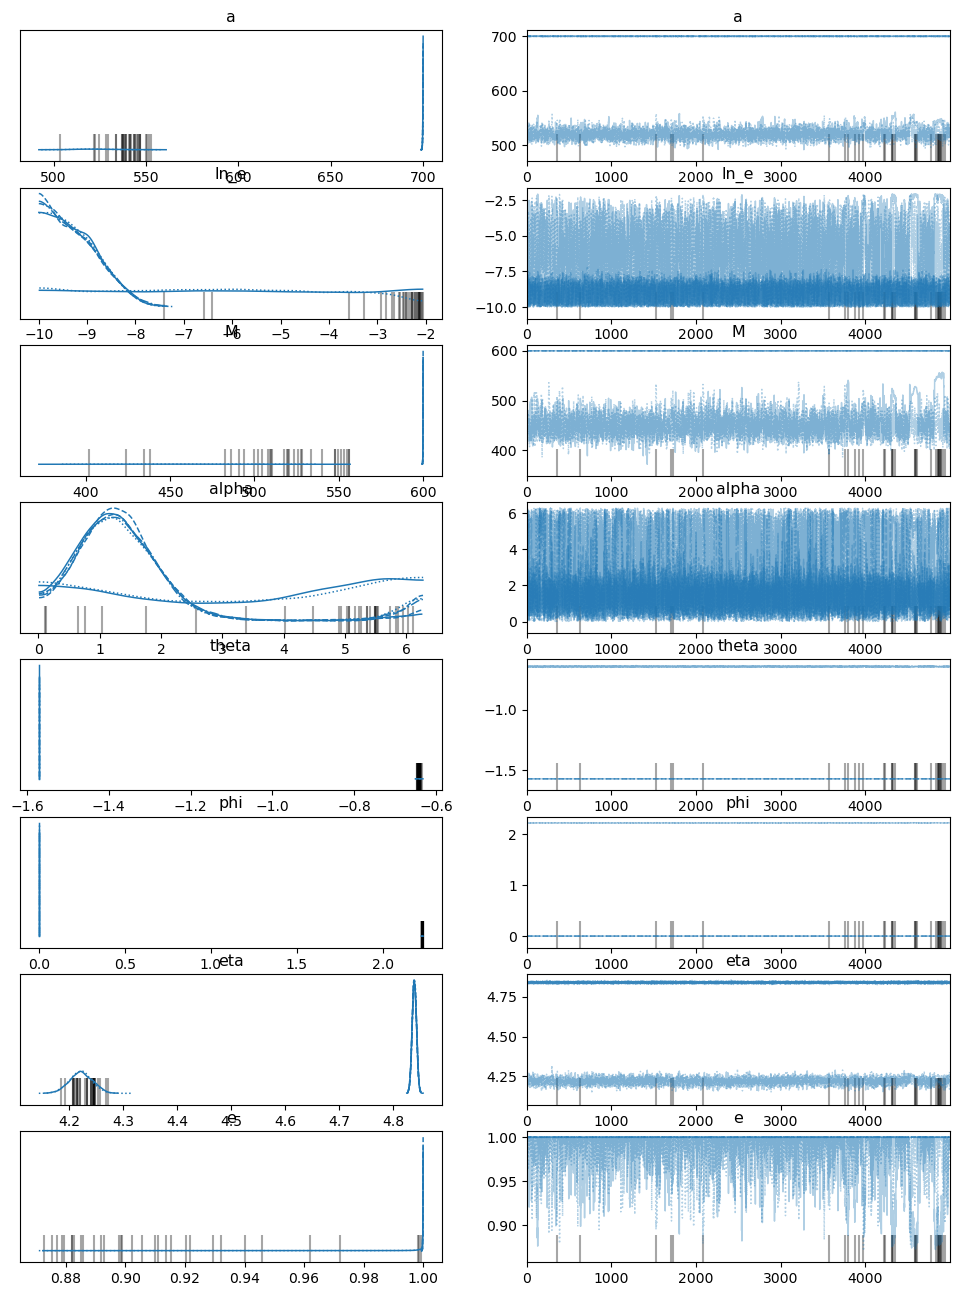

In [176]:
pm.summary(trace)
pm.plot_trace(trace)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'e'}>,
        <Axes: title={'center': 'M'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'eta'}>, <Axes: >, <Axes: >]],
      dtype=object)

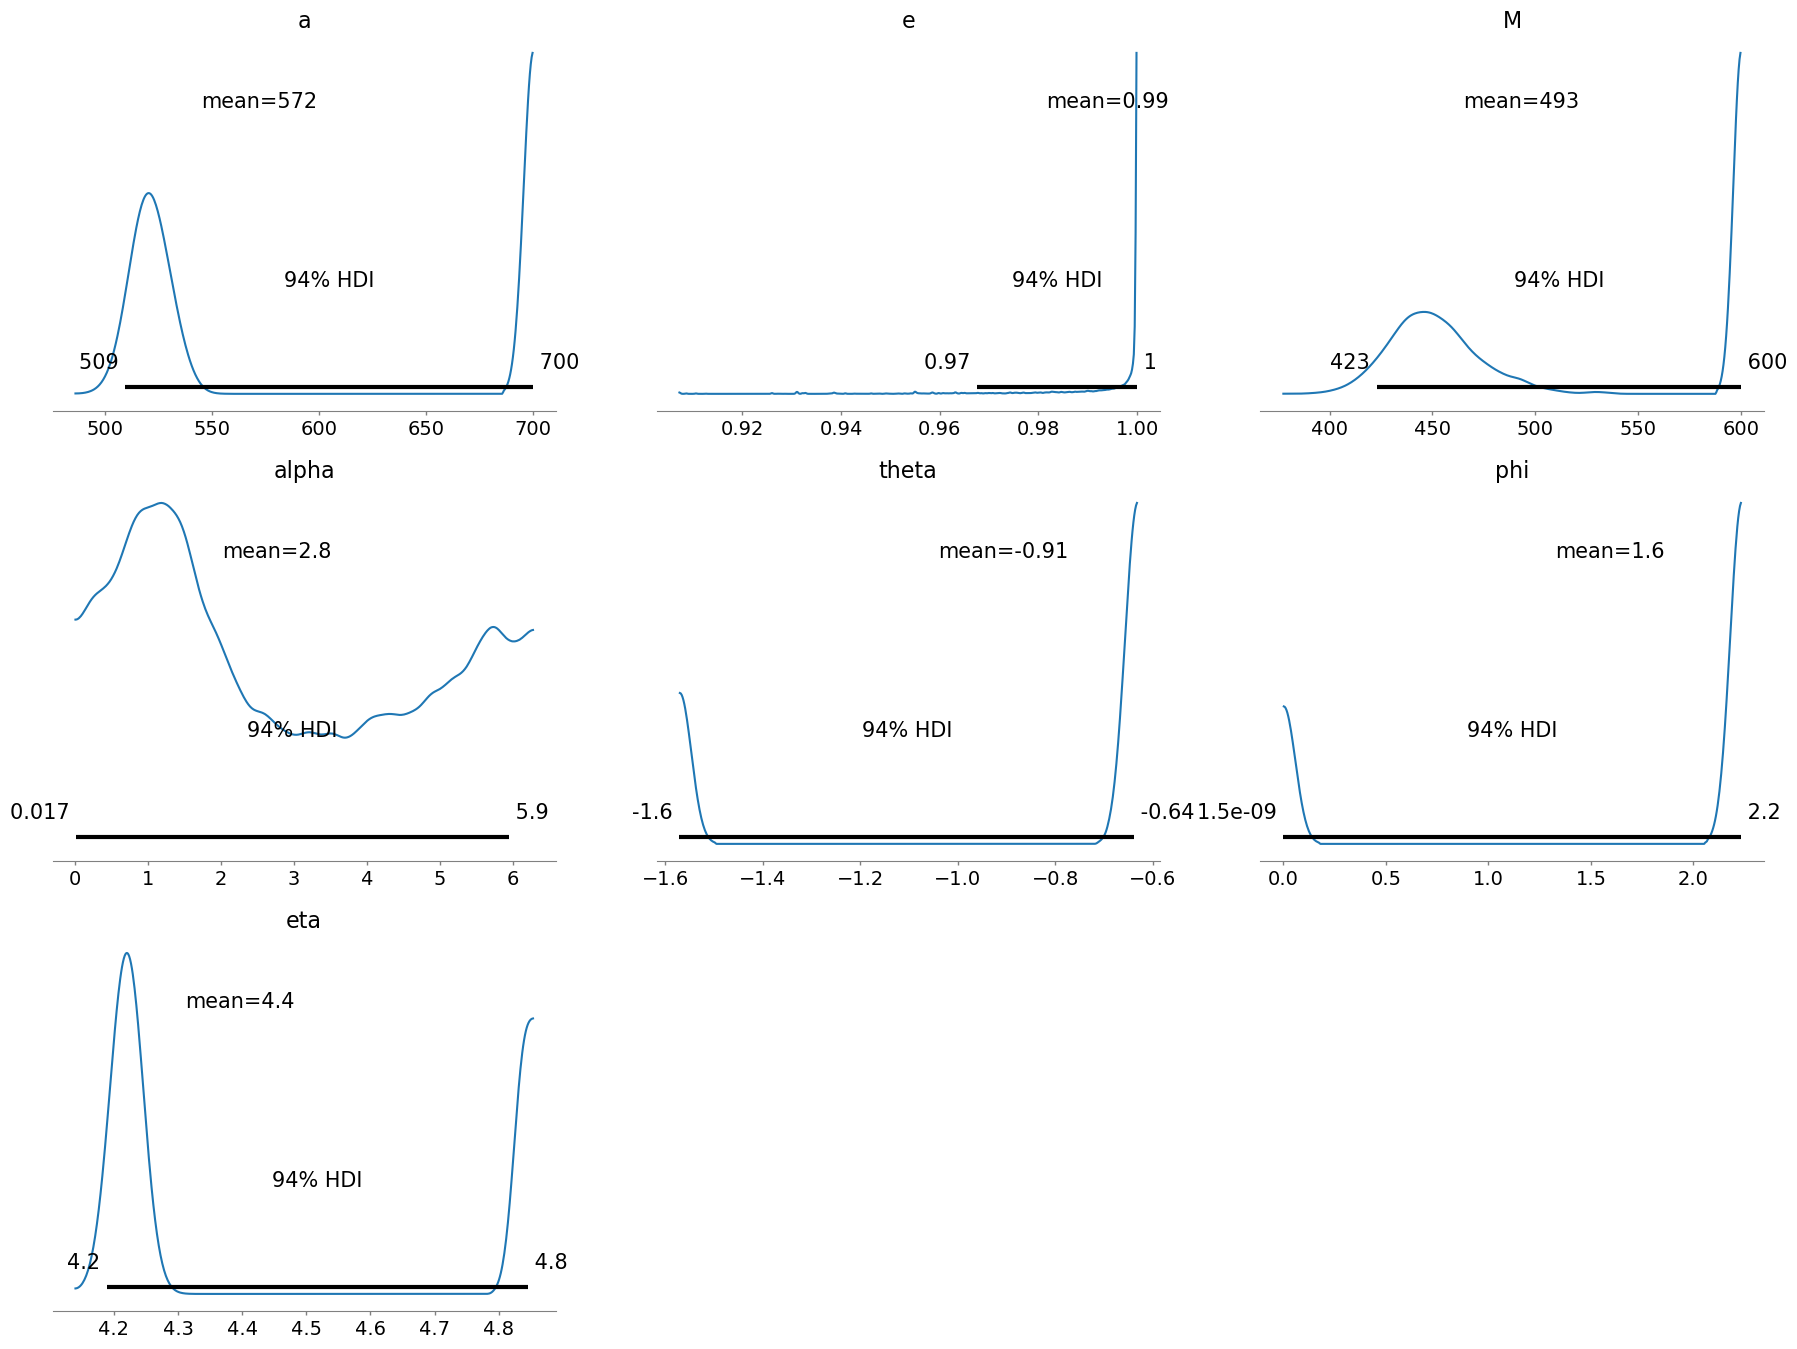

In [174]:
pm.plot_posterior(trace, var_names=['a', 'e', 'M', 'alpha', 'theta', 'phi', 'eta'])

In [70]:
np.arctan2(-1,1) * (180 / np.pi) +180

135.0

In [154]:
'''R_gal2icrs = np.array([
    [-0.0548755604, -0.8734370902, -0.4838350155],
    [0.4941094279, -0.4448296300, 0.7469822445],
    [-0.8676661490, -0.1980763734, 0.4559837762]
])



# 太阳位置和速度（Galactocentric 坐标系）
pos_sun_gal = np.array([-8.122, 0.0, 0.0208])  # kpc
vel_sun_gal = np.array([12.9, 245.6, 7.8])     # km/s

pos = np.array([-375.1316149740847,605.5277209737903,-278.83597703631733]) 
vel = np.array([37.53564320437491,-114.3816276001235,15.117831344570334])

# 转换到太阳坐标系
pos_gal = pos - pos_sun_gal
vel_gal = vel - vel_sun_gal

# 应用旋转矩阵
pos_icrs = np.dot(R_gal2icrs.T, pos_gal)
vel_icrs = np.dot(R_gal2icrs.T, vel_gal)

# 计算球坐标
x, y, z = pos_icrs[0], pos_icrs[1], pos_icrs[2]
distance = np.sqrt(x**2 + y**2 + z**2)
ra = np.arctan2(y, x) * (180 / np.pi) %360  # 转换为度数
dec = np.arcsin(z / distance) * (180 / np.pi)  # 转换为度数

# 计算自行 (mas/yr)
unit_vec = pos_icrs / distance
vr = np.sum(vel_icrs * unit_vec)
vt_vec = vel_icrs - vr * unit_vec

# 自行方向向量
east = np.stack([-np.sin(ra * np.pi/180), 
                    np.cos(ra * np.pi/180), 
                0.0]) 
north = np.stack([-np.cos(ra * np.pi/180) * np.sin(dec * np.pi/180),
                    -np.sin(ra * np.pi/180) * np.sin(dec * np.pi/180),
                    np.cos(dec * np.pi/180)])

pmra = (np.dot(east,vt_vec) / (distance * 4.74047))  
pmdec = (np.dot(north,vt_vec) / (distance * 4.74047)) 

print(f"RA: {ra}, DEC: {dec}, Distance: {distance}, PMRA: {pmra}, PMDEC: {pmdec}, VR: {vr}")'''

'R_gal2icrs = np.array([\n    [-0.0548755604, -0.8734370902, -0.4838350155],\n    [0.4941094279, -0.4448296300, 0.7469822445],\n    [-0.8676661490, -0.1980763734, 0.4559837762]\n])\n\n\n\n# 太阳位置和速度（Galactocentric 坐标系）\npos_sun_gal = np.array([-8.122, 0.0, 0.0208])  # kpc\nvel_sun_gal = np.array([12.9, 245.6, 7.8])     # km/s\n\npos = np.array([-375.1316149740847,605.5277209737903,-278.83597703631733]) \nvel = np.array([37.53564320437491,-114.3816276001235,15.117831344570334])\n\n# 转换到太阳坐标系\npos_gal = pos - pos_sun_gal\nvel_gal = vel - vel_sun_gal\n\n# 应用旋转矩阵\npos_icrs = np.dot(R_gal2icrs.T, pos_gal)\nvel_icrs = np.dot(R_gal2icrs.T, vel_gal)\n\n# 计算球坐标\nx, y, z = pos_icrs[0], pos_icrs[1], pos_icrs[2]\ndistance = np.sqrt(x**2 + y**2 + z**2)\nra = np.arctan2(y, x) * (180 / np.pi) %360  # 转换为度数\ndec = np.arcsin(z / distance) * (180 / np.pi)  # 转换为度数\n\n# 计算自行 (mas/yr)\nunit_vec = pos_icrs / distance\nvr = np.sum(vel_icrs * unit_vec)\nvt_vec = vel_icrs - vr * unit_vec\n\n# 自行方向向量\neast = np